In [ ]:
# 일반 크롬 브라우저는 보안 문제로 오류. 구글에서 직접 내려 받음
%%shell
sudo apt-get update
sudo apt-get install -y wget unzip

wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
sudo dpkg -i google-chrome-stable_current_amd64.deb
sudo apt-get -f install -y  # 의존성 오류 발생시 자동 수정

google-chrome --version

!apt-get -qq -y install fonts-nanum > /dev/null

In [ ]:
!pip install selenium
!pip install selenium webdriver_manager
!pip install gliner
!pip install konlpy

!apt-get update

Hit:1 https://dl.google.com/linux/chrome/deb stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://cli.github.com/packages stable InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
import re
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from wordcloud import WordCloud
from collections import Counter
from konlpy.tag import Okt
from tqdm import tqdm
from gliner import GLiNER
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By

In [ ]:
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

In [ ]:
# 봇 탐지 우회 및 크롬 GUI 없이 백그라운드 실행 설정
options = Options()
options.add_argument("--headless=new")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("--window-size=1920,1080")

# User-Agent 변경으로 봇 탐지 우회 설정
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
options.add_argument(f'user-agent={user_agent}')

# 자동화 제어 메시지 제거
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option('useAutomationExtension', False)
options.add_argument('--disable-blink-features=AutomationControlled')

# 드라이버 실행
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# 봇 탐지 방지용 스크립트 실행
driver.execute_cdp_cmd("Page.addScriptToEvaluateOnNewDocument", {
    "source": """
    Object.defineProperty(navigator, 'webdriver', {
      get: () => undefined
    })
  """
})

{'identifier': '2'}

In [ ]:
# 링크 수집
# 타겟 URL (개발 직군 전체 / 인천, 서울, 경기지역 한정 / 경력 신입 ~ 1년 / 정규 및 계약직)

print(" 채용공고 링크 수집 시작 ")
target_url = "https://www.wanted.co.kr/wdlist/518?country=kr&job_sort=job.latest_order&years=0&years=1&employment_types=job.employment_type.regular&employment_types=job.employment_type.contract&locations=seoul.all&locations=incheon.all&locations=gyeonggi.all"
driver.get(target_url)
time.sleep(3)

# 스크롤을 내려 확보할 데이터 양 결정
for i in range(30):
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)

# 링크 추출
all_links = driver.find_elements(By.TAG_NAME, "a")
job_links = []
for a in all_links:
    href = a.get_attribute("href")
    if href and "/wd/" in href:
        job_links.append(href)

# 중복 제거
job_links = list(set(job_links))
print(f" 총 {len(job_links)}개의 공고 링크를 확보 ")


# 상세 내용 크롤링
print(" 상세 페이지 내용 크롤링 중 ")

final_data = []

for link in tqdm(job_links):
    try:
        driver.get(link)
        time.sleep(2) # 페이지 로딩 대기

        soup = BeautifulSoup(driver.page_source, 'html.parser')

        # 제목 & 회사명
        try:
            title = soup.find("h1").text
        except:
            title = ""

        try:
            # 회사명은 h1 바로 위 a태그 혹은 class가 들어간 태그
            # 원티드 웹사이트 구조상 '회사정보' 링크 등을 통해 유추
            company_link = soup.select_one("a[href^='/company/']")
            company = company_link.text if company_link else ""
        except:
            company = ""

        # 본문 내용 추출 - 헤더 텍스트 기준
        def get_text_by_header(target_text):
            # h3, h2, strong 태그 중 target_text를 포함하는 것 찾기
            headers = soup.find_all(['h3', 'h2', 'strong'], string=lambda x: x and target_text in x)
            result_text = ""
            for h in headers:
                # 헤더 바로 다음 요소들(p, ul 등)의 텍스트 가져오기
                next_elem = h.find_next_sibling()
                if next_elem:
                    result_text += next_elem.get_text(separator=" ", strip=True)
            return result_text

        main_work = get_text_by_header("주요업무")
        qualification = get_text_by_header("자격요건")
        preference = get_text_by_header("우대사항")

        if title:
            final_data.append({
                'company': company,
                'title': title,
                'main_work': main_work,
                'qualification': qualification,
                'preference': preference,
                'link': link
            })

    except Exception as e:
        continue

df = pd.DataFrame(final_data)

print("-" * 50)
print(f" 크롤링 완료. 총 {len(df)}개의 데이터 수집")
print("-" * 50)

df.to_csv("wanted_job_data.csv", encoding="utf-8-sig", index=False)

df.head()

 채용공고 링크 수집 시작 
 총 661개의 공고 링크를 확보 
 상세 페이지 내용 크롤링 중 


100%|██████████| 661/661 [1:02:36<00:00,  5.68s/it]


--------------------------------------------------
 크롤링 완료. 총 661개의 데이터 수집
--------------------------------------------------


,company,title,main_work,qualification,preference,link
0,코넥시오에이치,"데이터 온톨로지 엔지니어 (병특 전문연구요원 Only, 석사이상)",**AI 기반 온톨로지 생성 시스템 개발 (핵심 업무)** • Legacy 비구조화...,"**학력 및 경력** • 컴퓨터공학, 데이터사이언스, 정보학 관련 석사 혹은 박사 ...",,https://www.wanted.co.kr/wd/302056
1,스트라드비젼(STRADVISION),A-SPICE Quality Manager,[Mission of the Role] • As a A-SPICE Quality M...,[Basic Qualifications] • Bachelor's of Science...,,https://www.wanted.co.kr/wd/301785
2,소만사,엔드포인트 보안에이전트 개발(C++기반),Privacy-와 Server-는 소만사에서 엔드포인트 보안을 책임지고 있는 제품입...,• 신입 & 경력 (경력년수 무관) • 학사 학위 또는 본인 경력에 준하는 프로그래...,,https://www.wanted.co.kr/wd/318643
3,주드라,EMS 서버개발자,합류하면 함께할 업무예요. • PCS/BMS/Meter 등에서 수집되는 Teleme...,이런 분과 함께하고 싶어요 • Java 및 Spring Boot 기반 서비스 개발 ...,,https://www.wanted.co.kr/wd/328910
4,놀유니버스,"Software Engineer, Backend - Search",[함께 할 업무예요] • 통합 검색 서비스 개발에 참여해요. • 검색 서비스의 다양...,[이런 분과 함께하고 싶어요] • 2년 이상의 소프트웨어 개발 경험과 1개 이상의 ...,,https://www.wanted.co.kr/wd/327668


In [ ]:
# 기술 스택 추출
def extract_tech_stack(text, model):
    if not isinstance(text, str) or len(text) < 5:
        return ""

    # 기술 스택 라벨
    tech_labels = [
        "Programming Language",
        "Framework & Library",
        "Database & Tool",
        "Cloud & DevOps",
        "AI & Data Stack"
    ]

    entities = model.predict_entities(text, tech_labels, threshold=0.3)

    found_techs = []
    for entity in entities:
        # 추출된 텍스트 저장
        found_techs.append(entity["text"])

    # 중복 제거 후 콤마로 연결
    return ', '.join(sorted(list(set(found_techs))))


# 소프트/하드 스킬 문장 추출
def extract_soft_hard_skill(text):
    if not isinstance(text, str):
        return "", ""

    # 문장 분리 (줄바꿈, 마침표, 불렛 포인트 기준)
    sentences = re.split(r'[.\n•·-]', text)
    sentences = [x.strip() for x in sentences if len(x.strip()) > 5]

    soft_skills = []
    hard_skills = []

    # 하드스킬(직무 역량)
    tech_keyword = [
        '설계', '구축', '운영', '개발', '경험', '최적화', '이해', '지식',
        '알고리즘', '구조', '아키텍처', '튜닝', '배포', '파이프라인', '테스트',
        'AWS', 'Cloud', 'API', 'DB', 'CI/CD', '트래픽', '대용량', '모델링'
    ]

    # 소프트 스킬 (태도 및 자세)
    soft_keyword = [
        '커뮤니케이션', '소통', '협업', '원활', '공유', '해결',
        '성장', '열정', '주도', '논리', '책임', '일정', '능동', '피드백',
        '비즈니스', '설득', '팀워크', '유연'
    ]

    for sent in sentences:
        # 1. 문장 끝맺음 패턴 (~분, ~능력, ~경험 등)
        if not re.search(r'(분|함|력|험|해|식|가능|필수|우대|중시)$', sent):
            continue

        # 2. 키워드 포함 여부 확인
        # 띄어쓰기 무시하고 검사하기 위해 변환
        is_hard = any(t in sent for t in tech_keyword)
        is_soft = any(t in sent for t in soft_keyword)

        # 3. 분류 로직 (소프트 키워드가 있으면 우선 소프트로 분류)
        if is_soft:
            soft_skills.append(sent)
        elif is_hard:
            hard_skills.append(sent)

    return " | ".join(soft_skills), " | ".join(hard_skills)


In [ ]:
# df = pd.read_csv("wanted_job_data.csv") # 런타임 종료로 데이터 증발 대비

model = GLiNER.from_pretrained("urchade/gliner_medium-v2.1")
okt = Okt()
tqdm.pandas()

df['full_text'] = (df['main_work'].fillna('') + ' ' + df['qualification'].fillna('') + ' ' + df['preference'].fillna(''))

print("기술 스택 추출")
df['Tech_Stack'] = df['full_text'].progress_apply(extract_tech_stack, model)

# 추출 결과가 튜플 형식 -> 리스트로 재가공
print("소프트 / 하드 스킬 추출")
df[['Soft_Skills', 'Hard_Skills']] = df['full_text'].progress_apply(
    lambda x: pd.Series(extract_soft_hard_skill(x)))

print("-" * 50)
print("분석 완료")
print("-" * 50)
print(df[['title', 'Tech_Stack', 'Soft_Skills', 'Hard_Skills']].head())

output_filename = "wanted_job_data_result.csv"
df.to_csv(output_filename, encoding="utf-8-sig", index=False)
print(f"파일 저장 완료: {output_filename}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

gliner_config.json:   0%|          | 0.00/476 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/781M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/781M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


기술 스택 추출


  7%|▋         | 47/661 [01:56<21:36,  2.11s/it]/usr/local/lib/python3.12/dist-packages/gliner/data_processing/processor.py:372: UserWarning: Sentence of length 468 has been truncated to 384
  batch = [self.preprocess_example(b["tokenized_text"], b[key], class_to_ids) for b in batch_list]
 24%|██▍       | 160/661 [06:49<13:39,  1.63s/it]/usr/local/lib/python3.12/dist-packages/gliner/data_processing/processor.py:372: UserWarning: Sentence of length 400 has been truncated to 384
  batch = [self.preprocess_example(b["tokenized_text"], b[key], class_to_ids) for b in batch_list]
 28%|██▊       | 187/661 [07:57<17:07,  2.17s/it]/usr/local/lib/python3.12/dist-packages/gliner/data_processing/processor.py:372: UserWarning: Sentence of length 496 has been truncated to 384
  batch = [self.preprocess_example(b["tokenized_text"], b[key], class_to_ids) for b in batch_list]
 30%|██▉       | 196/661 [08:34<18:17,  2.36s/it]/usr/local/lib/python3.12/dist-packages/gliner/data_processing/processor.py:372

소프트/하드 스킬 추출


100%|██████████| 661/661 [00:00<00:00, 4967.61it/s]


--------------------------------------------------
분석 완료
--------------------------------------------------
                                  title  \
0  데이터 온톨로지 엔지니어 (병특 전문연구요원 Only, 석사이상)   
1               A-SPICE Quality Manager   
2                엔드포인트 보안에이전트 개발(C++기반)   
3                             EMS 서버개발자   
4   Software Engineer, Backend - Search   

                                          Tech_Stack  \
0  Amazon Neptune, Apache Jena, ArangoDB, Java, N...   
1                                   Computer Science   
2                                               C++에   
3  Java, Kafka, RDB와 TSDB에, Redis를, Spring Boot, 고객사   
4                                                      

                                         Soft_Skills  \
0                                                      
1                                                      
2                                                      
3                                                      
4  문제를 논리적으로 분석하

['Amazon Neptune', 'Apache Jena', 'ArangoDB', 'Java', 'Neo4j', 'PyTorch', 'Python', 'Scala', 'TensorFlow', 'Transformer', 'Computer Science', 'C++에', 'Java', 'Kafka', 'RDB와 TSDB에', 'Redis를', 'Spring Boot', '고객사', 'PyTorch', 'Python', 'SQL', 'Scikit-learn', 'TensorFlow', 'Next.js', 'React', 'React Native', 'React.js', 'TypeScript를', 'Python', 'R', 'SQL', 'SQL을', '광고 네트워크 최적화 로직', '네트워크 알고리즘', 'AWS', 'Docker', 'FastAPI', 'GCP', 'Huggingface', 'Kubernetes', 'LLM', 'LangChain', 'LangGraph등을', 'OpenAI API', 'Python', 'Pytorch', 'C', 'C++', 'Go', 'Rust', '블록체인 기반 시스템을', 'AI Companion에', 'Bubble', 'Next.js', 'Nextjs', 'React Native를', 'TypeScript로', 'TypeScript에', '노코드', 'FastAPI', 'GCP', 'MongoDB', 'Open AI', 'PostgreSQL', 'firebase', 'langchain', 'nestjs', 'nextjs', 'nodejs', 'python', 'reactjs', 'typescript', 'Flutter', 'Linux', 'Python', 'React', 'C언어', 'C', 'C++', 'DICOM', 'PACS', 'Python', 'AI SDK', 'AWS', 'Claude Code', 'Cursor', 'Docker', 'GCP', 'Nest.js', 'Next.js', 'NoSQL', 'ORM', '

/tmp/ipython-input-594562341.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Tech', data=top_20, palette='viridis')


저장 완료: tech_stack_bar.png


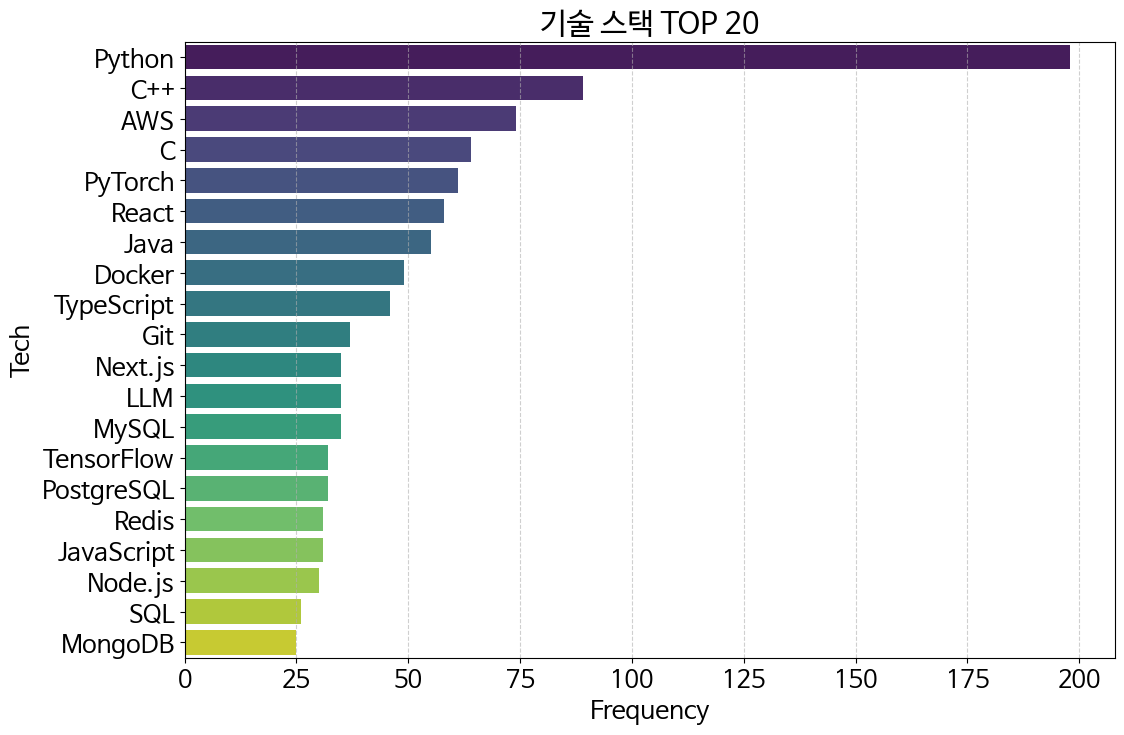

저장 완료: tech_stack_wordcloud.png


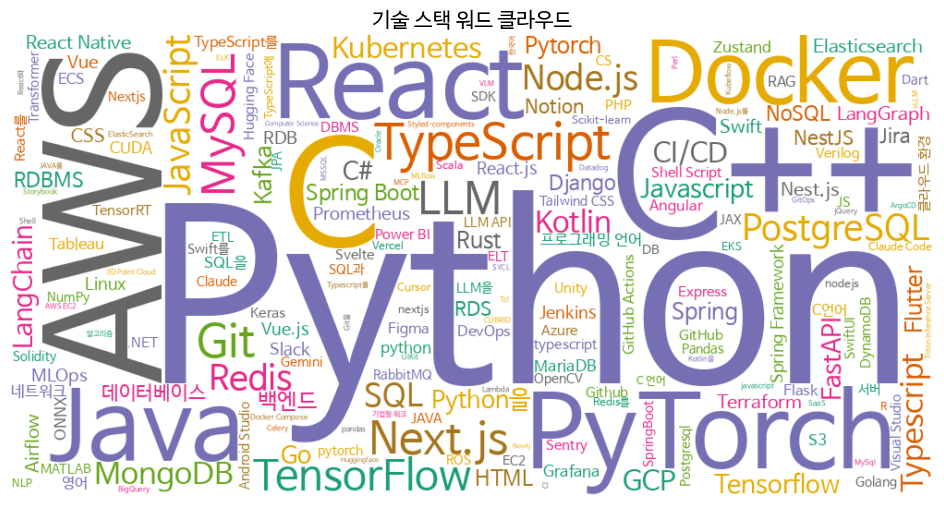

In [ ]:
# 데이터 전처리
all_techs = []

# df['Tech_Stack']이 NaN인 경우를 빈 문자열로 변경
for stack in df['Tech_Stack'].fillna(""):
    # 데이터가 문자열이 아니거나, 공백만 있는 경우 패스
    if not isinstance(stack, str) or not stack.strip():
        continue

    # 콤마로 분리하되, 각 아이템이 의미 있는 문자열인 경우만 저장(a, , b, 이나 ' ' 같은 요소들)
    techs = [t.strip() for t in stack.split(',') if t.strip()]
    all_techs.extend(techs)

# 빈도 분석
print(all_techs)
count_data = Counter(all_techs)
tech_df = pd.DataFrame(count_data.most_common(), columns=['Tech', 'Frequency'])

# 상위 10개 출력
print("=== 기술 스택 빈도 TOP 10 ===")
print(tech_df.head(10))

# 막대 그래프 시각화
plt.figure(figsize=(12, 8))
top_20 = tech_df.head(20).sort_values(by='Frequency', ascending=False)

sns.barplot(x='Frequency', y='Tech', data=top_20, palette='viridis')
plt.title('기술 스택 TOP 20')
plt.grid(axis='x', linestyle='--', alpha=0.6)

filename_bar = "tech_stack_bar.png"
plt.savefig(filename_bar, dpi=300, bbox_inches='tight')
print(f"저장 완료: {filename_bar}")
plt.show()

# 워드 클라우드 시각화
if count_data: # 데이터가 있을 때만 실행
    wc = WordCloud(
        width=1000,
        height=500,
        background_color='white',
        colormap='Dark2',
        font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
    )
    wc.generate_from_frequencies(count_data)

    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('기술 스택 워드 클라우드', fontsize=15)
    filename_wc = "tech_stack_wordcloud.png"
    plt.savefig(filename_wc, dpi=300, bbox_inches='tight')
    print(f"저장 완료: {filename_wc}")
    plt.show()
else:
    print("시각화할 데이터가 없습니다.")

텍스트 정제 및 명사 추출

In [ ]:
# 텍스트 정제 및 명사 추출
def extract_keywords_from_sentences(column_data, stop_words):
    all_keywords = []

    for text in column_data.fillna(""):
        # 빈 값 체크
        if not isinstance(text, str) or not text.strip():
            continue

        # 파이프(|)로 연결된 문장들 분리
        sentences = text.split('|')

        for sent in sentences:
            if not sent.strip(): continue

            # 명사 추출
            nouns = okt.nouns(sent)

            # 불용어 제거 및 2글자 이상 단어만 선택 -> 한글자 단어 일, 급, 팀 등은 의미가 없음
            clean_nouns = [
                n for n in nouns
                if n not in stop_words and len(n) >= 2
            ]
            all_keywords.extend(clean_nouns)
    return all_keywords

시각화 함수

In [ ]:
# 시각화 함수
def visualize_top_skills(keywords, title, text, color_palette='viridis'):
    if not keywords:
        print(f"[{title}] 시각화할 데이터가 없습니다.")
        return

    # 빈도 계산
    count_data = Counter(keywords)
    df_freq = pd.DataFrame(count_data.most_common(20), columns=['Keyword', 'Frequency'])

    # 막대 그래프
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Frequency', y='Keyword', data=df_freq, palette=color_palette)
    plt.title(f'{title} 빈도 TOP 20', fontsize=16)
    plt.xlabel('빈도수')
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    filename_wc = text+"_bargraph.png"
    plt.savefig(filename_wc, dpi=300, bbox_inches='tight')
    print(f"저장 완료: {filename_wc}")
    plt.show()

    # 워드 클라우드
    wc = WordCloud(
        width=800, height=400,
        background_color='white',
        font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
        colormap='coolwarm' if 'Hard' in title else 'summer'
    )
    wc.generate_from_frequencies(count_data)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{title} 워드 클라우드', fontsize=14)
    filename_wc = text+"_wordcloud.png"
    plt.savefig(filename_wc, dpi=300, bbox_inches='tight')
    print(f"저장 완료: {filename_wc}")
    plt.show()

요구하는 태도 및 자세 분석


/tmp/ipython-input-957446368.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=df_freq, palette=color_palette)


저장 완료: soft_skill_bargraph.png


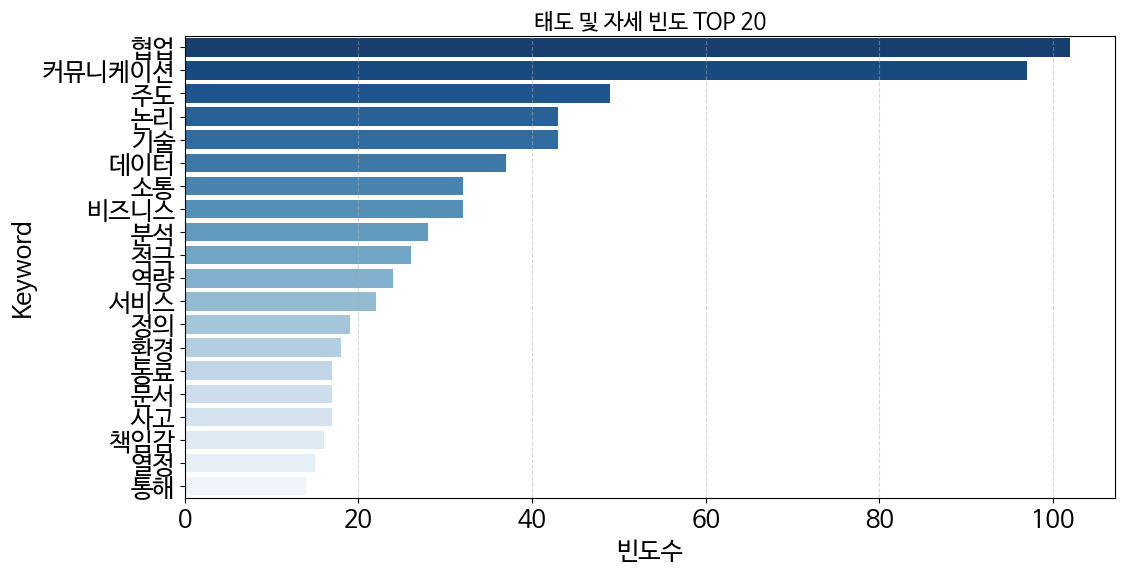

저장 완료: soft_skill_wordcloud.png


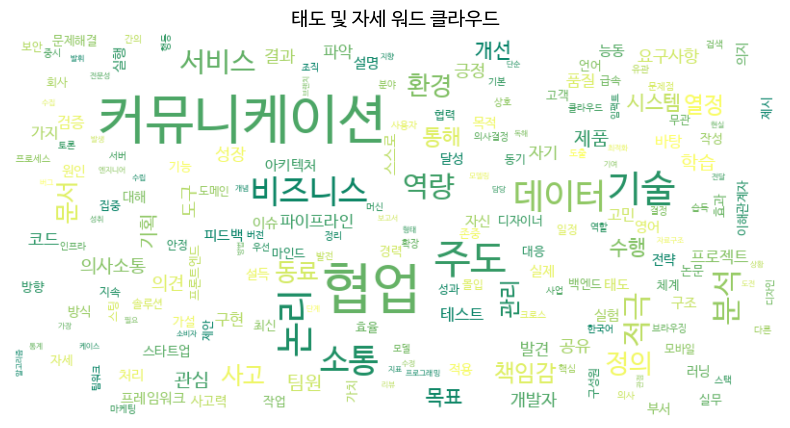

직무 역량 분석


/tmp/ipython-input-957446368.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=df_freq, palette=color_palette)


저장 완료: hard_skill_bargraph.png


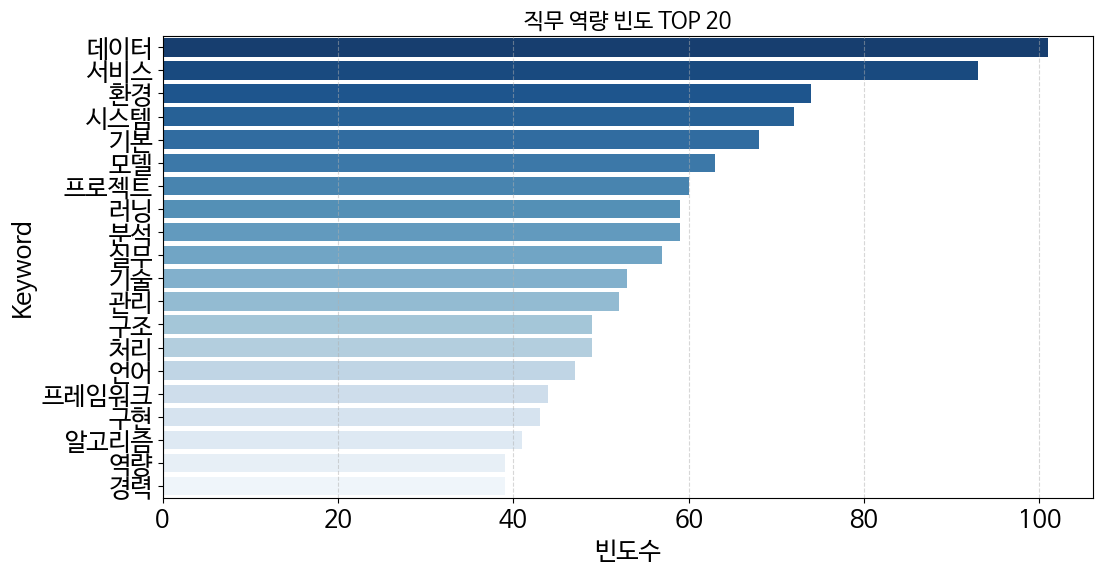

저장 완료: hard_skill_wordcloud.png


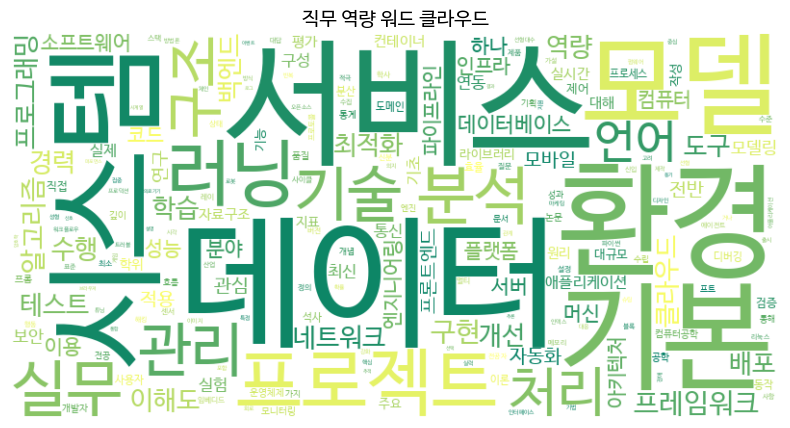

In [ ]:
okt = Okt()

# 불용어 리스트 정의 -> 공고에 자주 나오지만 쓸모없는 단어
# '개발','설계'는 너무 뻔해서 제외
stop_words_soft = set([
    '경험', '분', '능력', '우대', '필수', '자격', '업무', '등', '및', '대한',
    '활용', '이해', '관련', '보유', '기반', '통한', '위해', '가능', '지식',
    '사용', '구축', '운영', '개발', '설계', '문제',
    '우리', '모집', '채용', '생각', '사람', '해결', '과정', '참여', '이상',
])

stop_words_hard = set([
    '경험', '분', '능력', '우대', '필수', '자격', '업무', '등', '및', '대한',
    '활용', '이해', '관련', '보유', '기반', '통한', '위해', '가능', '지식',
    '사용', '구축', '운영', '개발', '설계', '문제',
    '우리', '모집', '채용', '생각', '사람', '해결', '과정', '참여', '이상',
])

print("요구하는 태도 및 자세 분석")
text = 'soft_skill'
soft_keywords = extract_keywords_from_sentences(df['Soft_Skills'], stop_words_soft)
visualize_top_skills(soft_keywords, "태도 및 자세", text, color_palette='Blues_r')

print("직무 역량 분석")
text = 'hard_skill'
hard_keywords = extract_keywords_from_sentences(df['Hard_Skills'], stop_words_hard)
visualize_top_skills(hard_keywords, "직무 역량", text, color_palette='Blues_r')